In [1]:
import pandas as pd
import numpy as np
import tqdm
import gc
import matplotlib.pyplot as plt
import talib as ta
import datetime as dt
import statsmodels.api as sm
pd.set_option('display.max_rows', 16)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '20070101'
END = '20241231'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']
# ST
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

In [5]:
st_df

,secID,tradeDate,STflg
0,000001.XSHE,2007-01-04,S
1,000001.XSHE,2007-01-05,S
2,000001.XSHE,2007-01-08,S
3,000001.XSHE,2007-01-09,S
4,000001.XSHE,2007-01-10,S
5,000001.XSHE,2007-01-11,S
6,000001.XSHE,2007-01-12,S
7,000001.XSHE,2007-01-15,S
...,...,...,...
553300,688555.XSHG,2023-05-29,*ST


In [6]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y%m%d').year
# end_ = dt.datetime.strptime(START, '%Y%m%d').year+3
# field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice','highestPrice','lowestPrice',"negMarketValue","turnoverValue",'turnoverVol']
# while begin_ <= 2024:
#     if begin_ == 2024:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [7]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   'openPrice','highestPrice','lowestPrice',
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverVol'],pandas="1")
# stk_df.to_pickle('./data/stk_df.pkl')
# # Takes about 6 mins

In [8]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [9]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12614538 entries, 0 to 12614537
Data columns (total 10 columns):
secID             object
tradeDate         object
preClosePrice     object
closePrice        object
openPrice         object
highestPrice      object
lowestPrice       object
negMarketValue    object
turnoverValue     object
turnoverVol       object
dtypes: object(10)
memory usage: 962.4+ MB


In [10]:
for col in stk_df.columns.drop(['secID','tradeDate']).tolist():
    stk_df[col] = pd.to_numeric(stk_df[col])

In [11]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(12614538, 10)
(12061713, 10)


In [12]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12061713 entries, 109 to 12614537
Data columns (total 10 columns):
secID             object
tradeDate         datetime64[ns]
preClosePrice     float64
closePrice        float64
openPrice         float64
highestPrice      float64
lowestPrice       float64
negMarketValue    float64
turnoverValue     float64
turnoverVol       int64
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 1012.3+ MB


不填充停牌值比较合理，因为技术分析只看量价，直接计算量价关系较为合适

In [13]:
random_stkid = np.random.choice(stk_df['secID'].unique(),1000)

stk_df = stk_df[stk_df['secID'].isin(random_stkid)].copy()

In [14]:
stk_df.drop(stk_df.loc[stk_df['openPrice']==0].index,inplace=True)

In [15]:
stk_df['open_ret'] = stk_df.groupby('secID')['openPrice'].apply(lambda x: x / x.shift() - 1)
stk_df['close_ret'] = stk_df['closePrice']/stk_df['preClosePrice'] - 1

In [16]:
def rule_return(df, demean=True, open_ret=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['close_ret_demean'] = df['close_ret'] - df['close_ret'].mean()
    df['open_ret_demean'] = df['open_ret'] - df['open_ret'].mean()
    df['position_close'] = df['signal']
    df['position_open'] = df['signal'].shift()
    df['position_close_ret'] = df['position_close'].shift() * df['close_ret']
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_close_ret_demean'] = df['position_close'].shift() * df['close_ret_demean']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    df['close_cumret'] = (df['position_close_ret']+1).cumprod()
    df['open_cumret'] = (df['position_open_ret']+1).cumprod()
    if open_ret:
        if demean:
            return pd.DataFrame({'position_open_ret_demean':df['position_open_ret_demean'].values, 
                                 'open_cumret':df['open_cumret'].values})
        else:
            return pd.DataFrame({'position_open_ret':df['position_open_ret'].values, 
                                 'open_cumret':df['open_cumret'].values})
    else:
        if demean:
            return pd.DataFrame({'position_close_ret_demean':df['position_close_ret_demean'].values, 
                                 'close_cumret':df['close_cumret'].values})
        else:
            return pd.DataFrame({'position_close_ret':df['position_close_ret'].values, 
                                 'close_cumret':df['close_cumret'].values})

# A bunch of TA signals

In [17]:
# EMA
stk_df['EMA'] = stk_df.groupby('secID')['closePrice'].apply(ta.EMA, 20)
stk_df['EM_signal'] = np.where(stk_df['closePrice']>stk_df['EMA'],1,np.nan)
stk_df.loc[stk_df['closePrice']<=stk_df['EMA'],'EM_signal'] = 0
stk_df['EM_signal'] = stk_df.groupby('secID')['EM_signal'].fillna(method='ffill')

In [18]:
stk_df['EM_signal'].value_counts()

0.0    1016812
1.0     944568
Name: EM_signal, dtype: int64

In [19]:
# MACD
stk_df['MACD'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[0])
stk_df['MACD_rawsignal'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[1])
stk_df['MACD_signal'] = np.where(stk_df['MACD']>stk_df['MACD_rawsignal'],1,np.nan)
stk_df.loc[stk_df['MACD']<=stk_df['MACD_rawsignal'],'MACD_signal'] = 0
stk_df['MACD_signal'] = stk_df.groupby('secID')['MACD_signal'].fillna(method='ffill')

In [20]:
stk_df['MACD_signal'].value_counts()

1.0    1014242
0.0     934465
Name: MACD_signal, dtype: int64

In [21]:
# # Example
# temp = stk_df[stk_df['secID']=='900957.XSHG'].copy()
# ta.OBV(temp['closePrice'],temp['turnoverValue'])
# stk_df.loc[9968491:]

In [22]:
# OBV
stk_df['OBV'] = stk_df.groupby('secID')[['closePrice','turnoverVol']].apply(lambda x: ta.OBV(real=x['closePrice'],volume=x['turnoverVol']).to_frame('OBV')).values
stk_df.groupby('secID')['OBV'].apply(lambda x: x/x.shift()-1)
stk_df['OBV_change'] = stk_df.groupby('secID')['OBV'].apply(lambda x: x/x.shift()-1)
buy1_OBV = (stk_df['close_ret']<0)&(stk_df['OBV_change']>0)
buy2_OBV = (stk_df['close_ret']>0)&(stk_df['OBV_change']>0)
sell1_OBV = (stk_df['close_ret']>0)&(stk_df['OBV_change']<0)
sell2_OBV = (stk_df['close_ret']<0)&(stk_df['OBV_change']<0)
stk_df['OBV_signal'] = 0
stk_df.loc[buy1_OBV | buy2_OBV,'OBV_signal']=1

In [23]:
stk_df['OBV_signal'].value_counts()

0    1002642
1     975971
Name: OBV_signal, dtype: int64

In [24]:
# AROON
N = 26
high_threshold = 70  # 强趋势
low_threshold = 30  # 弱趋势

stk_df['AROON_up'] = stk_df.groupby('secID')[['highestPrice','lowestPrice']].apply(lambda x:ta.AROON(high=x['highestPrice'],low=x['lowestPrice'])[0].to_frame('AROON_up')).values
stk_df['AROON_down'] = stk_df.groupby('secID')[['highestPrice','lowestPrice']].apply(lambda x:ta.AROON(high=x['highestPrice'],low=x['lowestPrice'])[1].to_frame('AROON_down')).values
buy_AROON = (stk_df['AROON_up']>high_threshold)&(stk_df['AROON_down']<low_threshold)
sell_AROON = (stk_df['AROON_down']>high_threshold)&(stk_df['AROON_up']<low_threshold)
stk_df['AROON_signal'] = np.where(buy_AROON,1,np.nan)
stk_df.loc[sell_AROON,'AROON_signal'] = 0
stk_df['AROON_signal'] = stk_df.groupby('secID')['AROON_signal'].fillna(method='ffill')

In [25]:
stk_df['AROON_signal'].value_counts()

0.0    983748
1.0    980565
Name: AROON_signal, dtype: int64

In [26]:
# BOLL
stk_df['BOLL_up'] = stk_df.groupby('secID')[['closePrice']].apply(lambda x:ta.BBANDS(real=x['closePrice'])[0].to_frame('BOLL_up')).values
stk_df['BOLL_mid'] = stk_df.groupby('secID')[['closePrice']].apply(lambda x:ta.BBANDS(real=x['closePrice'])[1].to_frame('BOLL_mid')).values
stk_df['BOLL_low'] = stk_df.groupby('secID')[['closePrice']].apply(lambda x:ta.BBANDS(real=x['closePrice'])[2].to_frame('BOLL_low')).values
stk_df['BOLL_up_lag'] = stk_df.groupby('secID')['BOLL_up'].shift()
stk_df['BOLL_mid_lag'] = stk_df.groupby('secID')['BOLL_mid'].shift()
stk_df['BOLL_low_lag'] = stk_df.groupby('secID')['BOLL_low'].shift()

buy_BOLL = (stk_df['preClosePrice'] < stk_df['BOLL_up_lag'])&(stk_df['closePrice']>stk_df['BOLL_up'])
sell_BOLL = (stk_df['preClosePrice'] > stk_df['BOLL_mid_lag'])&(stk_df['closePrice']<stk_df['BOLL_mid'])
stk_df['BOLL_signal'] = np.where(buy_BOLL, 1, np.nan)
stk_df.loc[sell_BOLL,'BOLL_signal'] = 0
stk_df['BOLL_signal'] = stk_df.groupby('secID')['BOLL_signal'].fillna(method='ffill')

In [27]:
stk_df['BOLL_signal'].value_counts()

0.0    1968545
1.0        265
Name: BOLL_signal, dtype: int64

In [28]:
# CCI
buy_threshold = -100  # 买入阈值
sell_threshold = 100  # 卖出阈值
stk_df['CCI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x:ta.CCI(high=x['highestPrice'],low=x['lowestPrice'],close=x['closePrice']).to_frame('CCI')).values

In [29]:
buy_CCI = stk_df['CCI']<buy_threshold
sell_CCI = stk_df['CCI']>sell_threshold
stk_df['CCI_signal'] = np.where(buy_CCI,1,np.nan)
stk_df.loc[sell_CCI,'CCI_signal'] = 0
stk_df['CCI_signal'] = stk_df.groupby('secID')['CCI_signal'].fillna(method='ffill')

In [30]:
stk_df['CCI_signal'].value_counts()

1.0    987828
0.0    976042
Name: CCI_signal, dtype: int64

In [31]:
# CMO
buy_threshold = -50  # 买入阈值
sell_threshold = 50
stk_df['CMO'] = stk_df.groupby('secID')['closePrice'].apply(ta.CMO)

In [32]:
buy_CMO = stk_df['CMO'] < buy_threshold
sell_CMO = stk_df['CMO'] > sell_threshold
stk_df['CMO_signal'] = np.where(buy_CMO, 1, np.nan)
stk_df.loc[sell_CMO,'CMO_signal'] = 0
stk_df['CMO_signal'] = stk_df.groupby('secID')['CMO_signal'].fillna(method='ffill')

In [33]:
stk_df['CMO_signal'].value_counts()

0.0    1129666
1.0     787311
Name: CMO_signal, dtype: int64

In [34]:
gc.collect()

44

In [35]:
# DMI
stk_df['plus_DI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x: ta.PLUS_DI(high=x['highestPrice'], low=x['lowestPrice'], close=x['closePrice']).to_frame()).values
stk_df['minus_DI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x: ta.MINUS_DI(high=x['highestPrice'], low=x['lowestPrice'], close=x['closePrice']).to_frame()).values
stk_df['ADX'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice']].apply(lambda x: ta.ADX(high=x['highestPrice'], low=x['lowestPrice'], close=x['closePrice']).to_frame()).values

In [36]:
buy_threshold = 50 
sell_threshold = 20
buy_DMI = (stk_df['ADX']>buy_threshold)&(stk_df['plus_DI']>stk_df['minus_DI'])
sell_DMI = (stk_df['ADX']<sell_threshold)|(stk_df['plus_DI']<stk_df['minus_DI'])
stk_df['DMI_signal'] = np.where(buy_DMI,1,np.nan)
stk_df.loc[sell_DMI,'DMI_signal'] = 0
stk_df['DMI_signal'] = stk_df.groupby('secID')['DMI_signal'].fillna(method='ffill')

In [37]:
stk_df['DMI_signal'].value_counts()

0.0    1881832
1.0      70271
Name: DMI_signal, dtype: int64

In [38]:
# MFI
stk_df['MFI'] = stk_df.groupby('secID')[['highestPrice','lowestPrice','closePrice','turnoverVol']].apply(lambda x:ta.MFI(high=x['highestPrice'],low=x['lowestPrice'],close=x['closePrice'],volume=x['turnoverVol']).to_frame()).values

In [39]:
buy_threshold = 20  
sell_threshold = 80 
buy_MFI = stk_df['MFI']<buy_threshold
sell_MFI = stk_df['MFI']>sell_threshold
stk_df['MFI_signal'] = np.where(buy_MFI,1,np.nan)
stk_df.loc[sell_MFI,'MFI_signal'] = 0
stk_df['MFI_signal'] = stk_df.groupby('secID')['MFI_signal'].fillna(method='ffill')

In [40]:
stk_df['MFI_signal'].value_counts()

0.0    1266671
1.0     669159
Name: MFI_signal, dtype: int64

In [41]:
# RSI
stk_df['RSI'] = stk_df.groupby('secID')['closePrice'].apply(ta.RSI)
buy_threshold = 30
sell_threshold = 70
buy_RSI = stk_df['RSI'] < buy_threshold
sell_RSI = stk_df['RSI'] > sell_threshold
stk_df['RSI_signal'] = np.where(buy_RSI,1,np.nan)
stk_df.loc[sell_RSI,'RSI_signal'] = 0
stk_df['RSI_signal'] = stk_df.groupby('secID')['RSI_signal'].fillna(method='ffill')

In [42]:
# %%time
# WVAD
# def wvad(df):
#     return sum((df[:,0] - df[:,1]) / (df[:,2] - df[:,3]) * df[:,4])

# stk_df.groupby('secID')[['closePrice','openPrice','highestPrice',
#                          'lowestPrice','turnoverVol']].apply(lambda x: x.rolling(24).apply(wvad,raw=False))
####### The above code is not working ##########

# temp = stk_df[stk_df['secID'].isin(np.random.choice(stk_df['secID'].unique(),10))].copy()
# def wvad(closePrice):
#     close = closePrice
#     open_ = stk_df.loc[closePrice.index, 'openPrice'].to_numpy()
#     high = stk_df.loc[closePrice.index, 'highestPrice'].to_numpy()
#     low = stk_df.loc[closePrice.index, 'lowestPrice'].to_numpy()
#     volume = stk_df.loc[closePrice.index, 'turnoverVol'].to_numpy()
#     return sum((closePrice - open_) / (high - low) * volume)
# temp2 = temp.groupby('secID')['closePrice'].rolling(24).apply(wvad, raw=False)

In [43]:
stk_df.reset_index(inplace=True, drop=True)

In [44]:
cols = ['secID','tradeDate','open_ret'] + [col for col in stk_df.columns if col[-6:]=='signal']

ret_df = stk_df[cols].copy()

ret_df['signal_date'] = ret_df['tradeDate']

ret_df[['tradeDate','open_ret']] = ret_df.groupby('secID')[['tradeDate','open_ret']].shift(-2)

ret_df.dropna(inplace=True)

ret_df.drop('MACD_rawsignal',axis=1,inplace=True)

ret_df['ret_sign'] = np.where(ret_df['open_ret']>0,1,-1)

ret_df

,secID,tradeDate,open_ret,EM_signal,MACD_signal,OBV_signal,AROON_signal,BOLL_signal,CCI_signal,CMO_signal,DMI_signal,MFI_signal,RSI_signal,signal_date,ret_sign
81,000004.XSHE,2011-10-11,0.000000,0.0,0.0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-09-30,-1
82,000004.XSHE,2011-10-12,-0.013465,0.0,0.0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-10,-1
83,000004.XSHE,2011-10-13,0.042886,0.0,0.0,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-11,1
84,000004.XSHE,2011-10-14,0.000000,0.0,0.0,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-12,-1
85,000004.XSHE,2011-10-17,0.003747,0.0,0.0,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-13,1
86,000004.XSHE,2011-10-18,-0.003733,0.0,0.0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-14,-1
87,000004.XSHE,2011-10-19,-0.026161,0.0,0.0,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-17,-1
88,000004.XSHE,2011-10-20,0.008636,0.0,0.0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2011-10-18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978603,689009.XSHG,2024-04-19,0.020643,1.0,0.0,1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2024-04-17,1


In [45]:
ret_df.sort_values('tradeDate',inplace=True)

ret_df.reset_index(inplace=True,drop=True)

In [46]:
ret_df

,secID,tradeDate,open_ret,EM_signal,MACD_signal,OBV_signal,AROON_signal,BOLL_signal,CCI_signal,CMO_signal,DMI_signal,MFI_signal,RSI_signal,signal_date,ret_sign
0,600446.XSHG,2007-03-01,0.039526,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1
1,600839.XSHG,2007-03-01,0.075766,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1
2,000883.XSHE,2007-03-01,0.087668,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1
3,600820.XSHG,2007-03-01,0.034152,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1
4,600004.XSHG,2007-03-01,0.063769,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1
5,002064.XSHE,2007-03-01,-0.024068,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,-1
6,600170.XSHG,2007-03-01,0.058523,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1
7,000729.XSHE,2007-03-01,0.057694,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894386,603728.XSHG,2024-04-30,-0.041047,1.0,1.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2024-04-26,-1


# Random Forest

## Train, test split

In [47]:
ret_df['year'] = ret_df['tradeDate'].dt.year

In [48]:
time_idx = [value for (key, value) in sorted(ret_df.groupby('year').groups.items())]

In [54]:
ret_df

,secID,tradeDate,open_ret,EM_signal,MACD_signal,OBV_signal,AROON_signal,BOLL_signal,CCI_signal,CMO_signal,DMI_signal,MFI_signal,RSI_signal,signal_date,ret_sign,year
0,600446.XSHG,2007-03-01,0.039526,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
1,600839.XSHG,2007-03-01,0.075766,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
2,000883.XSHE,2007-03-01,0.087668,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1,2007
3,600820.XSHG,2007-03-01,0.034152,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1,2007
4,600004.XSHG,2007-03-01,0.063769,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1,2007
5,002064.XSHE,2007-03-01,-0.024068,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,-1,2007
6,600170.XSHG,2007-03-01,0.058523,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
7,000729.XSHE,2007-03-01,0.057694,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894386,603728.XSHG,2024-04-30,-0.041047,1.0,1.0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2024-04-26,-1,2024


In [49]:
def list_flat(list_):
    return [item for sublist in list_ for item in sublist]
# This is the same as:
# def list_flat2(list_):
#     result = []
#     for sublist in list_:
#         for item in sublist:
#             result.append(item)
#     return result

In [50]:
list_flat([[1,2,3],[3,4,5]])

[1, 2, 3, 3, 4, 5]

In [51]:
np.array([[1,2,3],[3,4,5]]).flatten()

array([1, 2, 3, 3, 4, 5])

In [60]:
# training, validation, testing scheme:
# 1. [2007-2010], [2011-2014], [2015]
# 2. [2008-2011], [2012-2015], [2016]
# ...
# last. [2015-2018], [2019-2022], [2023]
fulltrain_idx = []
cv_idx = []
test_idx = []
for i in range(4,len(time_idx)-4):
    train_idx = list_flat(time_idx[i-4:i])
    val_idx = list_flat(time_idx[i:i+4])
    fulltrain_idx.append(train_idx + val_idx)
    cv_idx.append((np.where(np.isin(fulltrain_idx[-1], train_idx))[0], 
                   np.where(np.isin(fulltrain_idx[-1], val_idx))[0])) # GridSearchCV 内部用 array 操作，不能带着pandas的index，
                                                                          # 因此cv_idx需要用fulltrain_idx的编号从0开始
    test_idx.append(time_idx[i+4])

In [61]:
len(fulltrain_idx)

10

In [62]:
len(fulltrain_idx[0])

555676

In [63]:
len(fulltrain_idx[1])

616665

In [64]:
cv_idx

[(array([     0,      1,      2, ..., 207453, 207454, 207455]),
  array([207456, 207457, 207458, ..., 555673, 555674, 555675])),
 (array([     0,      1,      2, ..., 252001, 252002, 252003]),
  array([252004, 252005, 252006, ..., 616662, 616663, 616664])),
 (array([     0,      1,      2, ..., 286794, 286795, 286796]),
  array([286797, 286798, 286799, ..., 667427, 667428, 667429])),
 (array([     0,      1,      2, ..., 320579, 320580, 320581]),
  array([320582, 320583, 320584, ..., 724690, 724691, 724692])),
 (array([     0,      1,      2, ..., 348217, 348218, 348219]),
  array([348220, 348221, 348222, ..., 788921, 788922, 788923])),
 (array([     0,      1,      2, ..., 364658, 364659, 364660]),
  array([364661, 364662, 364663, ..., 849727, 849728, 849729])),
 (array([     0,      1,      2, ..., 380630, 380631, 380632]),
  array([380633, 380634, 380635, ..., 908646, 908647, 908648])),
 (array([     0,      1,      2, ..., 404108, 404109, 404110]),
  array([404111, 404112, 404113, 

In [66]:
test_years = list(range(2015, 2025))
test_years

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [67]:
X_cols = [col for col in ret_df.columns if col[-6:]=='signal']

In [68]:
X_cols

['EM_signal',
 'MACD_signal',
 'OBV_signal',
 'AROON_signal',
 'BOLL_signal',
 'CCI_signal',
 'CMO_signal',
 'DMI_signal',
 'MFI_signal',
 'RSI_signal']

# Evaluation metrics

用 accuracy, f1_score 作为好坏评价的标准

- accuracy: 正确数/总数。比如预测了100次，对了99次，则accuracy = 99%. $accuracy = \frac{TP+TN}{TP+TN+FP+FN}$
- $precision = \frac{TP}{TP+FP}$, 在预测为Positive时，预测对的次数
- $recall = \frac{TP}{TP+FN}$，在真实为Positive时，预测对的次数
- $f1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} $

# Random forest

In [69]:
hyperparam_grid = [
    {'n_estimators': [50], 'max_depth': [3,5,7], 
     'max_features': [5,8]}
]

In [70]:
model = RandomForestClassifier()

In [71]:
# Cross validation for period 0, i.e.
# train: [2008-2011], val: [2012-2015], test: [2016]
grid_search = GridSearchCV(model, hyperparam_grid, cv=[cv_idx[0]])

In [72]:
X_fulltrain = ret_df.loc[fulltrain_idx[0], X_cols]
y_fulltrain = ret_df.loc[fulltrain_idx[0], 'ret_sign']
X_test = ret_df.loc[test_idx[0], X_cols]
y_test = ret_df.loc[test_idx[0], 'ret_sign']

In [73]:
ret_df.loc[fulltrain_idx[0]]

,secID,tradeDate,open_ret,EM_signal,MACD_signal,OBV_signal,AROON_signal,BOLL_signal,CCI_signal,CMO_signal,DMI_signal,MFI_signal,RSI_signal,signal_date,ret_sign,year
0,600446.XSHG,2007-03-01,0.039526,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
1,600839.XSHG,2007-03-01,0.075766,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
2,000883.XSHE,2007-03-01,0.087668,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1,2007
3,600820.XSHG,2007-03-01,0.034152,1.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1,2007
4,600004.XSHG,2007-03-01,0.063769,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,1,2007
5,002064.XSHE,2007-03-01,-0.024068,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2007-02-27,-1,2007
6,600170.XSHG,2007-03-01,0.058523,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
7,000729.XSHE,2007-03-01,0.057694,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007-02-27,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555668,002266.XSHE,2014-12-31,0.003762,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-12-29,1,2014


In [74]:
%%time
grid_search.fit(X_fulltrain, y_fulltrain)

CPU times: user 24.4 s, sys: 192 ms, total: 24.6 s
Wall time: 24.6 s


GridSearchCV(cv=[(array([     0,      1,      2, ..., 207453, 207454, 207455]),
                  array([207456, 207457, 207458, ..., 555673, 555674, 555675]))],
             estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 5, 7], 'max_features': [5, 8],
                          'n_estimators': [50]}])

In [75]:
grid_search.best_params_

{'max_depth': 3, 'max_features': 8, 'n_estimators': 50}

In [76]:
pd.DataFrame({"features":X_cols,"feature_importance":grid_search.best_estimator_.feature_importances_}).sort_values('feature_importance',ascending=False)

,features,feature_importance
1,MACD_signal,0.354916
2,OBV_signal,0.330150
9,RSI_signal,0.101991
3,AROON_signal,0.080836
0,EM_signal,0.058099
6,CMO_signal,0.037543
5,CCI_signal,0.033019
8,MFI_signal,0.003447
4,BOLL_signal,0.000000
7,DMI_signal,0.000000


In [77]:
y_pred = grid_search.predict(X_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred))

0.5344297522419498


In [78]:
# Benchmark all-positive
all_ones = np.ones_like(y_pred)
accuracy_score(y_true=y_test, y_pred=all_ones)

0.5521632288331223

In [79]:
y_pred = grid_search.predict(X_test)
print(f1_score(y_true=y_test, y_pred=y_pred))
print(f1_score(y_true=y_test, y_pred=all_ones))

0.6060366012836553
0.7114757244290922


In [80]:
%%time
for i in range(len(fulltrain_idx)):
    X_fulltrain = ret_df.loc[fulltrain_idx[i], X_cols]
    y_fulltrain = ret_df.loc[fulltrain_idx[i], 'ret_sign']
    X_test = ret_df.loc[test_idx[i], X_cols]
    y_test = ret_df.loc[test_idx[i], 'ret_sign']
    
    grid_search = GridSearchCV(model, hyperparam_grid, cv=[cv_idx[i]])
    grid_search.fit(X_fulltrain, y_fulltrain)
    y_pred = grid_search.predict(X=X_test)
    
    all_ones = np.ones_like(y_pred)
    print("Test year", test_years[i],"Benchmark","accuracy:",accuracy_score(y_true=y_test, y_pred=all_ones))
    print("Test year", test_years[i],"Model","accuracy:",accuracy_score(y_true=y_test, y_pred=y_pred))
    print("Test year", test_years[i],"Benchmark","f1:",f1_score(y_true=y_test, y_pred=all_ones))
    print("Test year", test_years[i],"Model","f1:",f1_score(y_true=y_test, y_pred=y_pred))
    print("====================我是分割线========================")

Test year 2015 Benchmark accuracy: 0.5521632288331223
Test year 2015 Model accuracy: 0.5368126549152686
Test year 2015 Benchmark f1: 0.7114757244290922
Test year 2015 Model f1: 0.6182790514180511
====================我是分割线========================
Test year 2016 Benchmark accuracy: 0.4969889034630004
Test year 2016 Model accuracy: 0.5259318123067201
Test year 2016 Benchmark f1: 0.6639847527437387
Test year 2016 Model f1: 0.6221065565638142
====================我是分割线========================
Test year 2017 Benchmark accuracy: 0.47659027107831636
Test year 2017 Model accuracy: 0.5049843993081811
Test year 2017 Benchmark f1: 0.645528120309603
Test year 2017 Model f1: 0.6135589540390539
====================我是分割线========================
Test year 2018 Benchmark accuracy: 0.4652777231809426
Test year 2018 Model accuracy: 0.4937379613978537
Test year 2018 Benchmark f1: 0.6350710391895952
Test year 2018 Model f1: 0.5920040549958817
====================我是分割线========================
Test year 2019 B

# Return

In [82]:
len(test_years)

10

In [81]:
i = 8
print(test_years[i])
X_fulltrain = ret_df.loc[fulltrain_idx[i], X_cols]
y_fulltrain = ret_df.loc[fulltrain_idx[i], 'ret_sign']
X_test = ret_df.loc[test_idx[i], X_cols]

grid_search = GridSearchCV(model, hyperparam_grid, cv=[cv_idx[i]])
grid_search.fit(X_fulltrain, y_fulltrain)
rule = grid_search.predict(X=X_test)

2023


In [83]:
rule

array([ 1, -1, -1, ..., -1, -1, -1])

In [84]:
rule[rule==-1] = 0

In [85]:
rule

array([1, 0, 0, ..., 0, 0, 0])

In [86]:
len(rule)

197857

In [87]:
ret_df.loc[test_idx[i],'open_ret']

1630115    0.002366
1630116   -0.002650
1630117   -0.007888
1630118   -0.004739
1630119    0.009130
1630120   -0.005476
1630121   -0.005021
1630122    0.002462
             ...   
1827964    0.019915
1827965    0.022737
1827966    0.028913
1827967    0.086711
1827968    0.012177
1827969    0.019474
1827970    0.017527
1827971    0.030625
Name: open_ret, Length: 197857, dtype: float64

In [88]:
rule_ret = ret_df.loc[test_idx[i],'open_ret'].values * rule

In [91]:
ret_df_2023 = ret_df.loc[test_idx[i],['secID','tradeDate','open_ret']].copy()
ret_df_2023['rule_ret'] = rule_ret

In [92]:
ret_df_2023

,secID,tradeDate,open_ret,rule_ret
1630115,600668.XSHG,2023-01-03,0.002366,0.002366
1630116,002063.XSHE,2023-01-03,-0.002650,-0.000000
1630117,002531.XSHE,2023-01-03,-0.007888,-0.000000
1630118,688355.XSHG,2023-01-03,-0.004739,-0.000000
1630119,002111.XSHE,2023-01-03,0.009130,0.000000
1630120,600075.XSHG,2023-01-03,-0.005476,-0.005476
1630121,300176.XSHE,2023-01-03,-0.005021,-0.000000
1630122,000901.XSHE,2023-01-03,0.002462,0.002462
...,...,...,...,...
1827964,600158.XSHG,2023-12-29,0.019915,0.000000


In [93]:
ret_df_2023.sort_values(['secID','tradeDate'],inplace=True)

In [94]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = ret_df_2023.groupby('secID')['rule_ret'].mean()
rule_tsmean_ret_by_crs

secID
000004.XSHE    0.007459
000006.XSHE   -0.000702
000025.XSHE    0.000675
000028.XSHE    0.000139
000039.XSHE    0.000260
000069.XSHE   -0.001601
000078.XSHE   -0.000126
000089.XSHE   -0.000351
                 ...   
688716.XSHG    0.001008
688728.XSHG    0.000769
688766.XSHG    0.001060
688776.XSHG   -0.000723
688798.XSHG   -0.001486
688799.XSHG    0.000629
688800.XSHG   -0.001309
689009.XSHG    0.000535
Name: rule_ret, Length: 852, dtype: float64

In [95]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [96]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,0.000060
t_values,0.581422


In [99]:
ret_df_2023['1+rule_ret'] = ret_df_2023['rule_ret'] + 1

In [100]:
ret_df_2023['cum_rule_ret'] = ret_df_2023.groupby('secID')['1+rule_ret'].cumprod()

In [101]:
ret_df_2023['1+open_ret'] = ret_df_2023['open_ret'] + 1
ret_df_2023['cum_open_ret'] = ret_df_2023.groupby('secID')['1+open_ret'].cumprod()

In [102]:
ret_df_2023

,secID,tradeDate,open_ret,rule_ret,1+rule_ret,cum_rule_ret,1+open_ret,cum_open_ret
1722700,000004.XSHE,2023-06-28,0.263864,0.263864,1.263864,1.263864,1.263864,1.263864
1723257,000004.XSHE,2023-06-29,0.004054,0.004054,1.004054,1.268988,1.004054,1.268988
1724468,000004.XSHE,2023-06-30,0.043072,0.043072,1.043072,1.323645,1.043072,1.323645
1725185,000004.XSHE,2023-07-03,-0.024517,-0.024517,0.975483,1.291193,0.975483,1.291193
1725760,000004.XSHE,2023-07-04,-0.107143,-0.000000,1.000000,1.291193,0.892857,1.152850
1726577,000004.XSHE,2023-07-05,0.066672,0.066672,1.066672,1.377279,1.066672,1.229713
1727502,000004.XSHE,2023-07-06,0.159721,0.000000,1.000000,1.377279,1.159721,1.426124
1728850,000004.XSHE,2023-07-07,0.062273,0.000000,1.000000,1.377279,1.062273,1.514933
...,...,...,...,...,...,...,...,...
1821829,689009.XSHG,2023-12-20,-0.011458,-0.011458,0.988542,1.175496,0.988542,0.998714


In [103]:
final_ret_2023 = ret_df_2023.groupby('secID').last()

In [104]:
final_ret_2023.sort_values('cum_rule_ret')

,tradeDate,open_ret,rule_ret,1+rule_ret,cum_rule_ret,1+open_ret,cum_open_ret
secID,,,,,,,
300392.XSHE,2023-07-07,-0.083737,-0.000000,1.000000,0.056079,0.916263,0.051384
300336.XSHE,2023-07-04,0.000000,0.000000,1.000000,0.147211,1.000000,0.147211
300751.XSHE,2023-12-29,0.242990,0.000000,1.000000,0.416117,1.242990,0.513590
002667.XSHE,2023-12-29,0.063454,0.063454,1.063454,0.603489,1.063454,0.463151
603363.XSHG,2023-12-29,0.032578,0.032578,1.032578,0.610962,1.032578,0.476697
603236.XSHG,2023-12-29,0.058833,0.000000,1.000000,0.628931,1.058833,0.742282
300896.XSHE,2023-12-29,0.131578,0.000000,1.000000,0.631157,1.131578,0.535539
300438.XSHE,2023-12-29,0.107719,0.000000,1.000000,0.636066,1.107719,0.362389
...,...,...,...,...,...,...,...


In [106]:
best_sec = final_ret_2023.sort_values('cum_rule_ret').index[-5:]

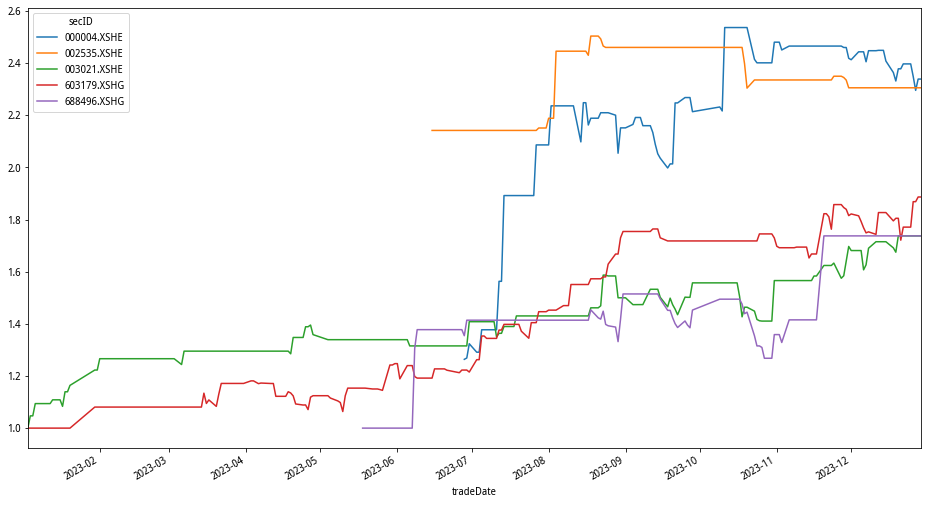

In [107]:
ret_df_2023.loc[ret_df_2023['secID'].isin(best_sec)].pivot(index='tradeDate',columns='secID',values='cum_rule_ret').plot()

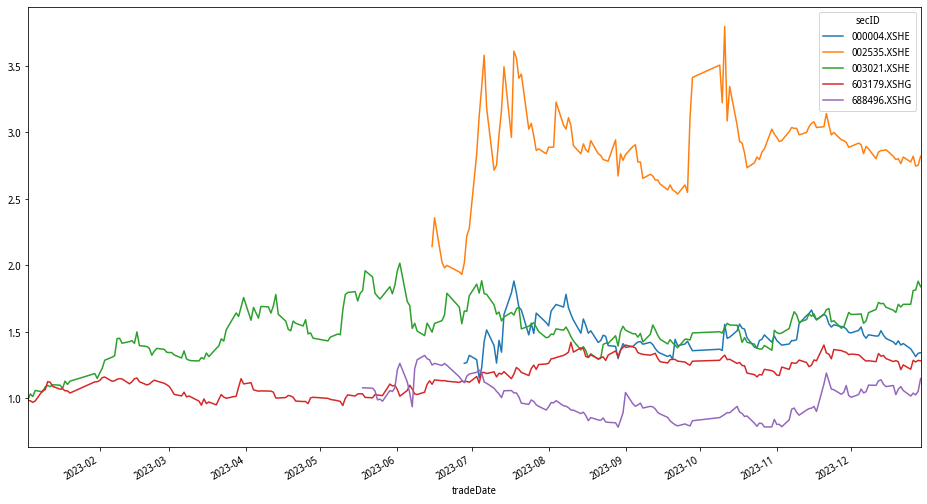

In [108]:
ret_df_2023.loc[ret_df_2023['secID'].isin(best_sec)].pivot(index='tradeDate',columns='secID',values='cum_open_ret').plot()

In [109]:
final_ret_2023.sort_values('cum_rule_ret', inplace=True)
worst_sec = final_ret_2023.loc[final_ret_2023['tradeDate']=='2023-12-30'].index[0:10]

In [95]:
final_ret_2022

,tradeDate,open_ret,rule_ret,1+rule_ret,cum_rule_ret,1+open_ret,cum_open_ret
secID,,,,,,,
002464.XSHE,2022-06-27,-0.038462,-0.038462,0.961538,0.097306,0.961538,0.097306
600091.XSHG,2022-06-15,-0.026223,-0.026223,0.973777,0.104188,0.973777,0.100244
600695.XSHG,2022-06-07,0.041337,0.041337,1.041337,0.141306,1.041337,0.141306
600652.XSHG,2022-06-15,-0.107438,-0.000000,1.000000,0.257113,0.892562,0.288000
688608.XSHG,2022-12-30,0.005591,0.005591,1.005591,0.459943,1.005591,0.605369
000056.XSHE,2022-12-30,0.004424,0.004424,1.004424,0.490503,1.004424,0.857958
300482.XSHE,2022-12-30,-0.023919,-0.023919,0.976081,0.496035,0.976081,0.826127
300589.XSHE,2022-12-30,0.020557,0.020557,1.020557,0.496537,1.020557,0.740127
...,...,...,...,...,...,...,...


In [96]:
worst_sec

Index(['688608.XSHG', '000056.XSHE', '300482.XSHE', '300589.XSHE',
       '300543.XSHE', '688339.XSHG', '603176.XSHG', '300545.XSHE',
       '300977.XSHE', '601908.XSHG'],
      dtype='object', name='secID')

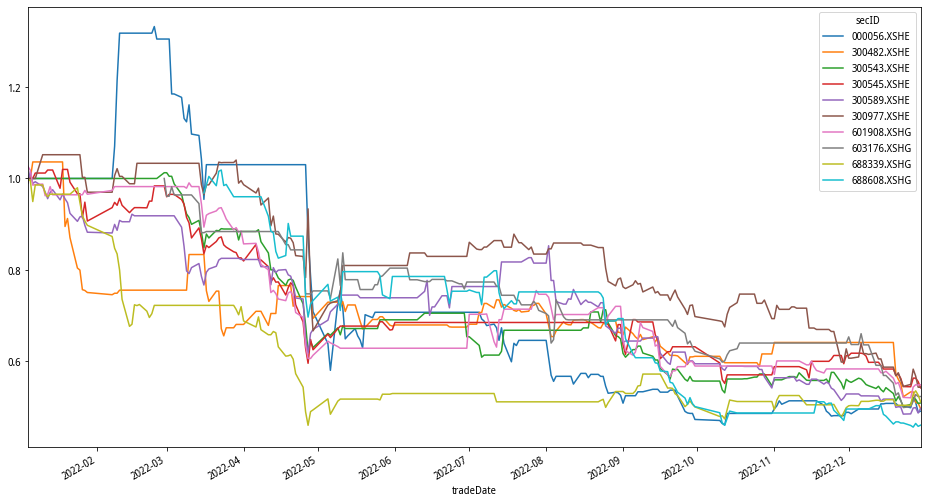

In [97]:
ret_df_2022.loc[ret_df_2022['secID'].isin(worst_sec)].pivot(index='tradeDate',columns='secID',values='cum_rule_ret').plot()

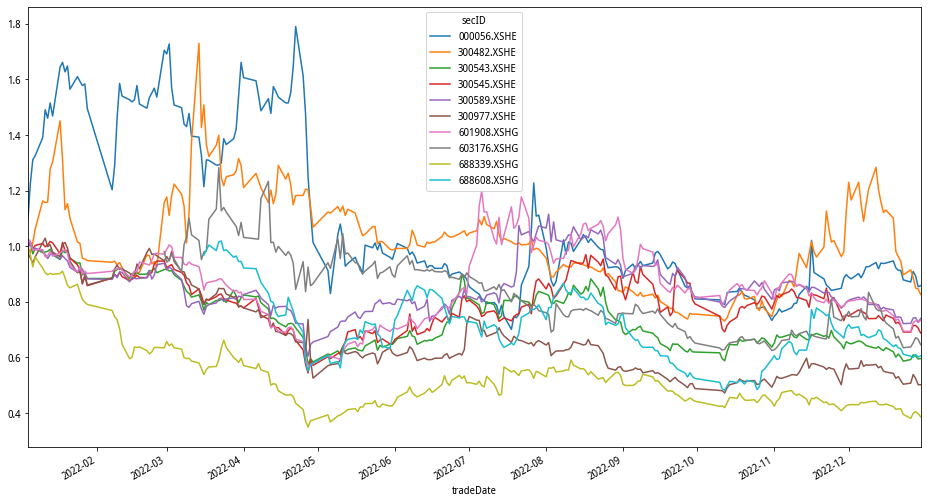

In [98]:
ret_df_2022.loc[ret_df_2022['secID'].isin(worst_sec)].pivot(index='tradeDate',columns='secID',values='cum_open_ret').plot()